In [1]:
import rasterio as rio
import rioxarray as riox
from matplotlib import pyplot
from src.constants import INTERMEDIATE_RESULTS
from src.data.pipelines.extract_gedi_data import SIERRAS_GEDI_ID_COLUMNS, SEKI_GEDI_ID_COLUMNS
from src.data.processing import disturbance_overlays as do
from src.data.adapters import disturbance_agents as da
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src import constants
from src.data.utils import gedi_utils
from src.data.processing import overlay
from fastai.tabular.all import load_pickle, save_pickle
from src.data.pipelines import aggregate_analysis as aa
from src.data.adapters import mtbs

sns.set_theme(style="white", palette="Set2")

import importlib
#importlib.reload(raster)
importlib.reload(do)
importlib.reload(da)

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
palette = sns.color_palette("Set2")

2024-01-24 20:15:28,714 DEBUG: Logger /home/jk871/fire-regen/src/data/utils/raster.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-01-24 20:15:28,831 DEBUG: Logger /home/jk871/fire-regen/src/data/utils/raster.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-01-24 20:15:28,833 DEBUG: Logger /home/jk871/fire-regen/src/data/processing/disturbance_overlays.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2024-01-24 20:15:28,834 DEBUG: Logger /home/jk871/fire-regen/src/data/adapters/disturbance_agents.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


In [2]:
df_in = load_pickle(f"{aa.PIPELINES_PATH}/severity_aggregated_info_da.pkl")

In [3]:
df_in.loc[df_in.YSF < 0, "pre_fire_ndvi"] = df_in.ndvi
df_in["ndvi_ratio"] = df_in["ndvi"] / df_in["pre_fire_ndvi"]

burned = df_in[df_in.YSF > 0]
unburned = df_in[df_in.YSF < 0]
burned = mtbs.get_burn_severity(burned)

df = pd.concat([burned, unburned])

In [4]:
dfp = burned

# Stratifying based on pre-fire NDVI

We noticed that pre-fire NDVI values strongly influence the trends visible in 

In [5]:
def open(df):
    return df[df.pre_fire_ndvi < 0.67]

def closed(df):
    return df[df.pre_fire_ndvi > 0.67]

In [6]:
def plot_1(metric, sharey=False):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5), sharey=sharey)
    sns.pointplot(open(dfp), x="YSF_cat_5", y=metric, ax=ax[0], errorbar=("pi", 50), capsize=.15, hue="severity")
    ax[0].axhline(open(unburned)[metric].mean(), color="red", linestyle="dotted")
    ax[0].set_title("Low pre-fire NDVI")

    sns.pointplot(closed(dfp), x="YSF_cat_5", y=metric, ax=ax[1], errorbar=("pi", 50), capsize=.15, hue="severity")
    ax[1].axhline(closed(unburned)[metric].mean(), color="red", linestyle="dotted")
    ax[1].set_title("High pre-fire NDVI")

def plot_2(metric):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    sns.pointplot(open(dfp[dfp.severity == 0]), x="YSF_cat_5", y=metric, ax=ax[0], errorbar=("pi", 50), capsize=.15)
    sns.pointplot(closed(dfp[dfp.severity == 0]), x="YSF_cat_5", y=metric, ax=ax[0], errorbar=("pi", 50), capsize=.15, alpha=0.7)
    ax[0].axhline(open(unburned)[metric].mean(), color="red", linestyle="dotted")
    ax[0].axhline(closed(unburned)[metric].mean(), color="red", linestyle="dotted")
    ax[0].set_title("Low Severity")

    sns.pointplot(open(dfp[dfp.severity == 2]), x="YSF_cat_5", y=metric, ax=ax[1], errorbar=("pi", 50), capsize=.15)
    sns.pointplot(closed(dfp[dfp.severity == 2]), x="YSF_cat_5", y=metric, ax=ax[1], errorbar=("pi", 50), capsize=.15, alpha=0.7)
    ax[1].axhline(open(unburned)[metric].mean(), color="red", linestyle="dotted")
    ax[1].axhline(closed(unburned)[metric].mean(), color="red", linestyle="dotted")
    ax[1].set_title("High Severity")
def plots(metric, sharey=False):
    plot_1(metric, sharey)
    plot_2(metric)

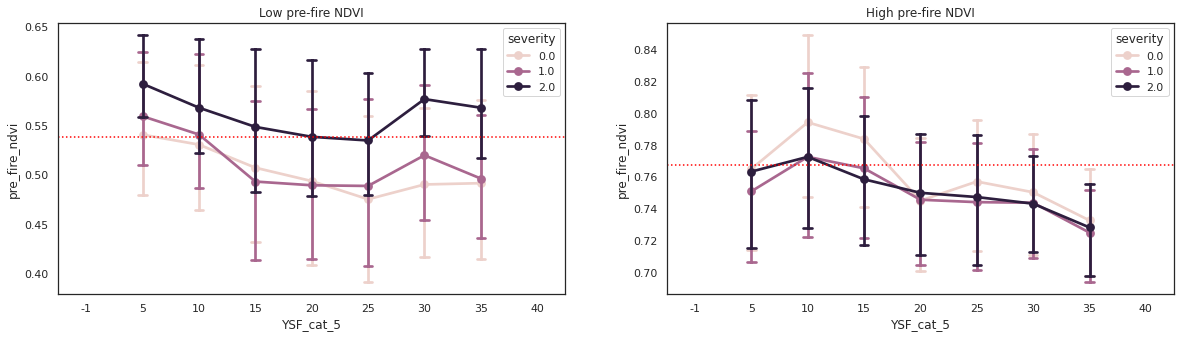

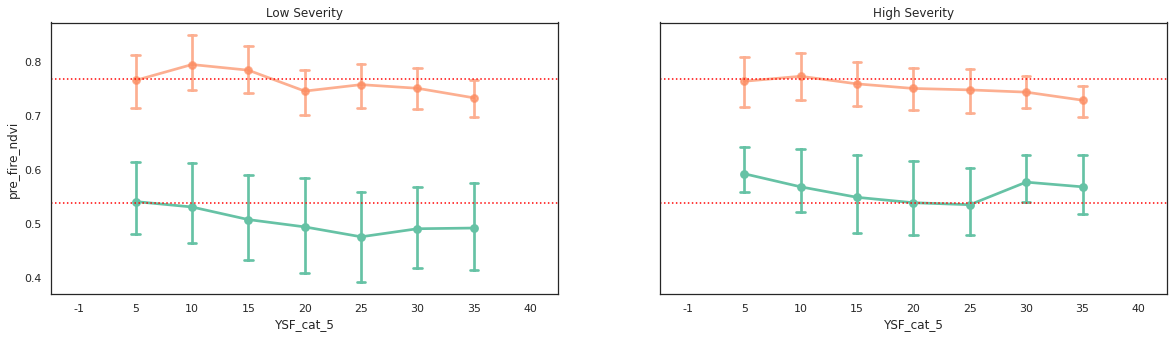

In [33]:
plots("pre_fire_ndvi")

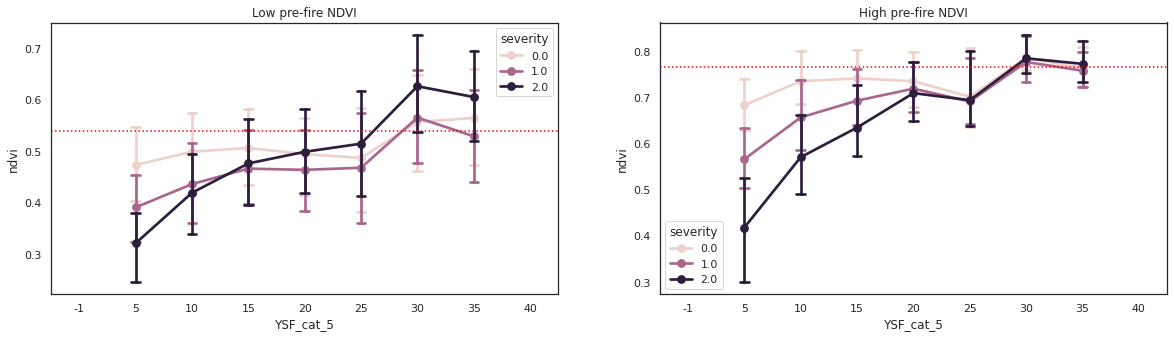

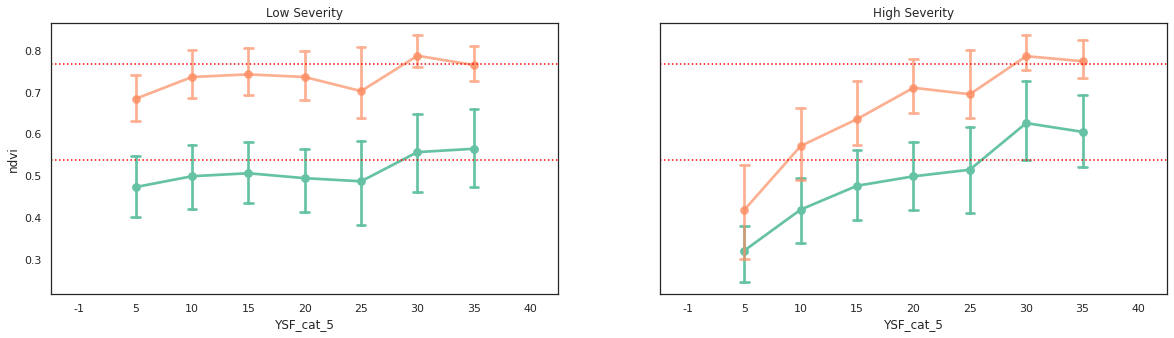

In [34]:
plots("ndvi")

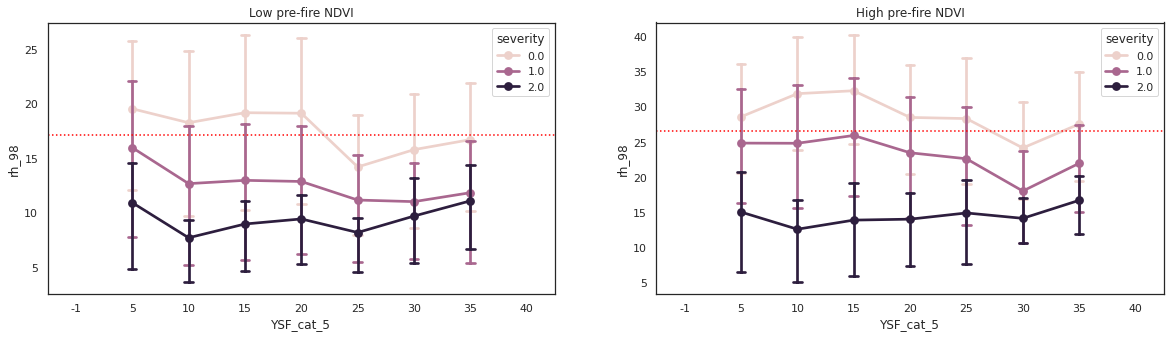

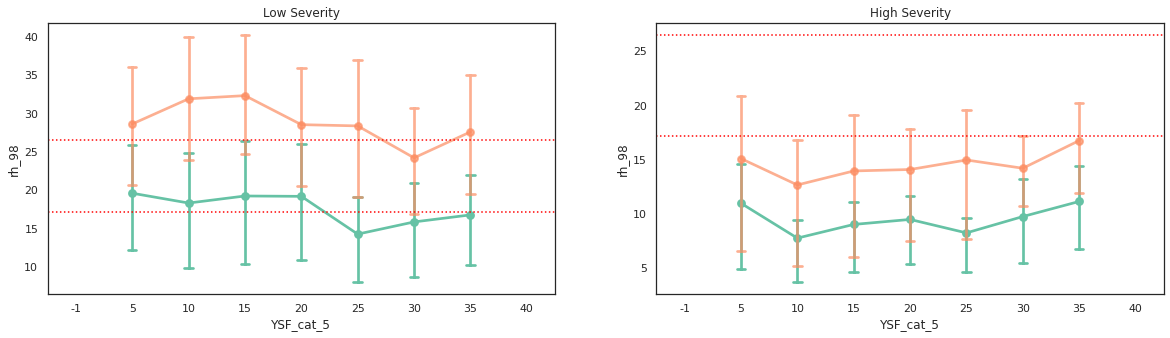

In [37]:
plots("rh_98")

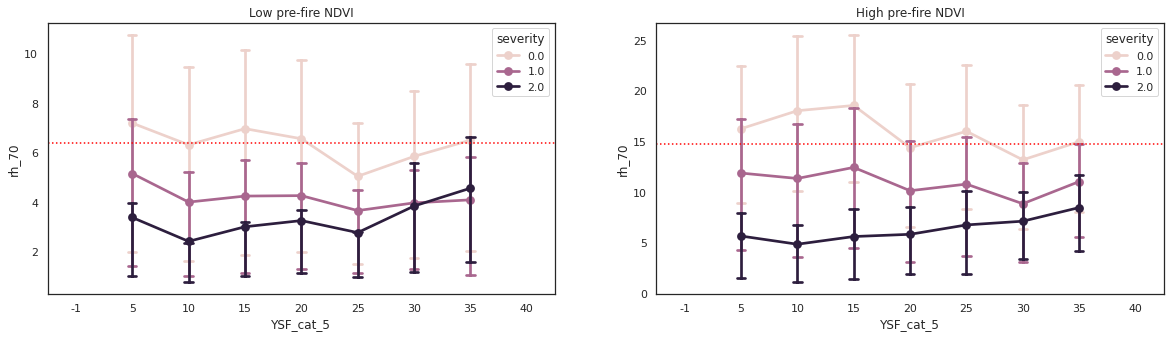

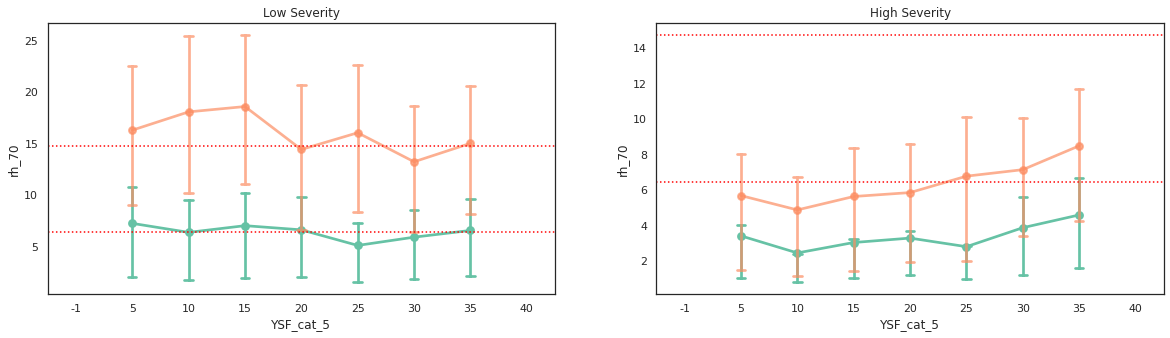

In [38]:
plots("rh_70")

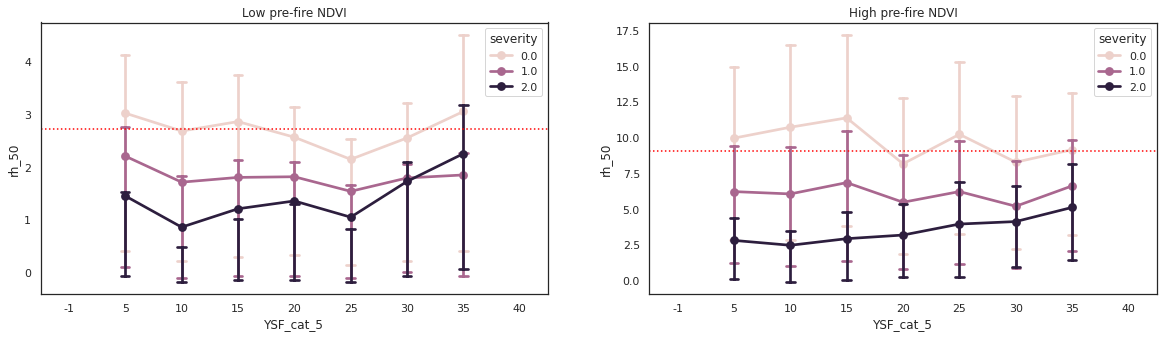

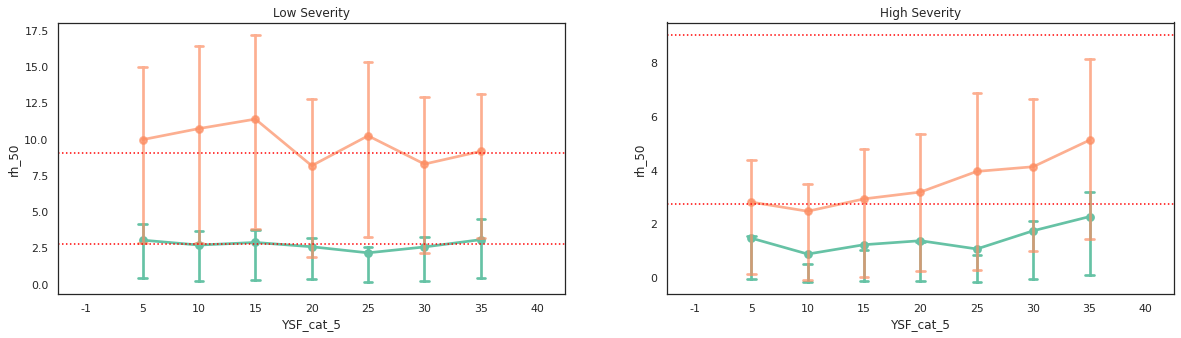

In [39]:
plots("rh_50")

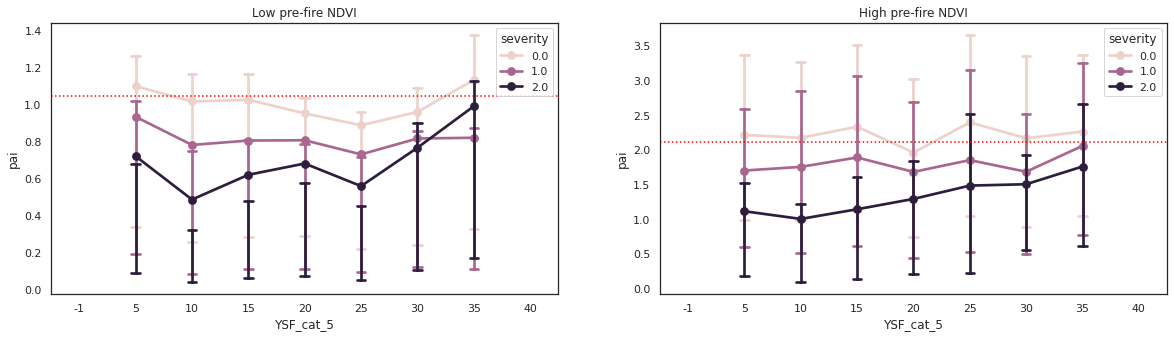

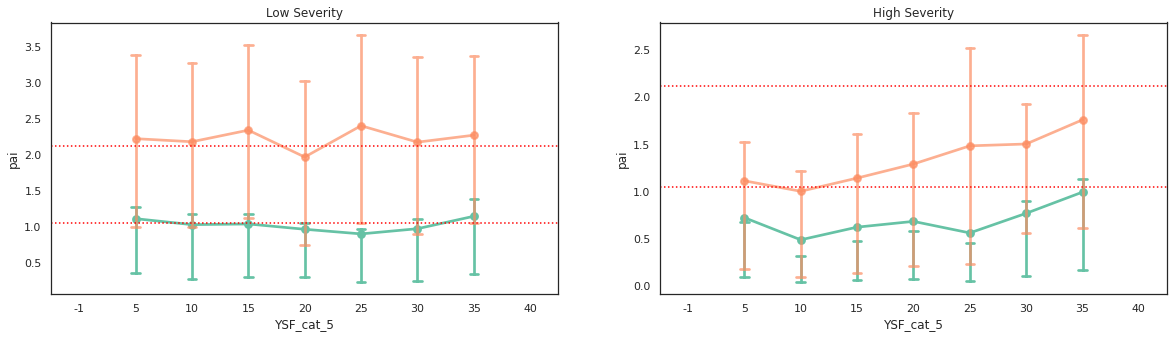

In [40]:
plots("pai")

### PDF Plot

186999


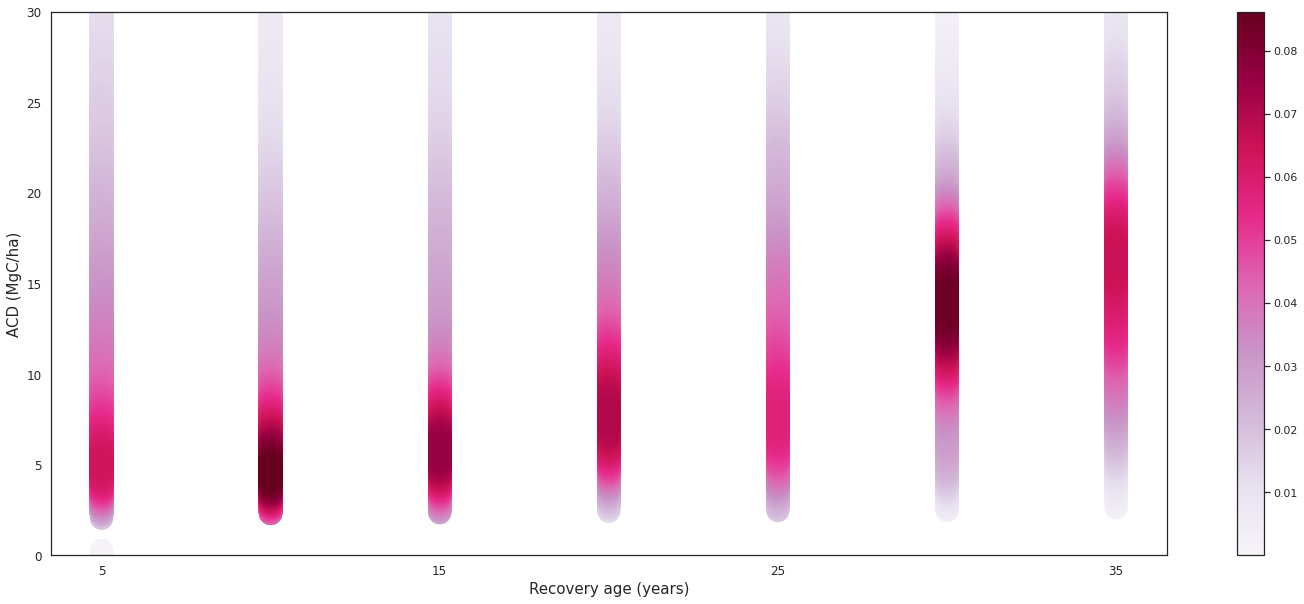

In [11]:
from src.visualization.dists import plot_pdf
dft = closed(burned)
plot_pdf(dft[dft.severity == 2],
         'YSF_cat_5',
         'rh_98',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 30))

186999


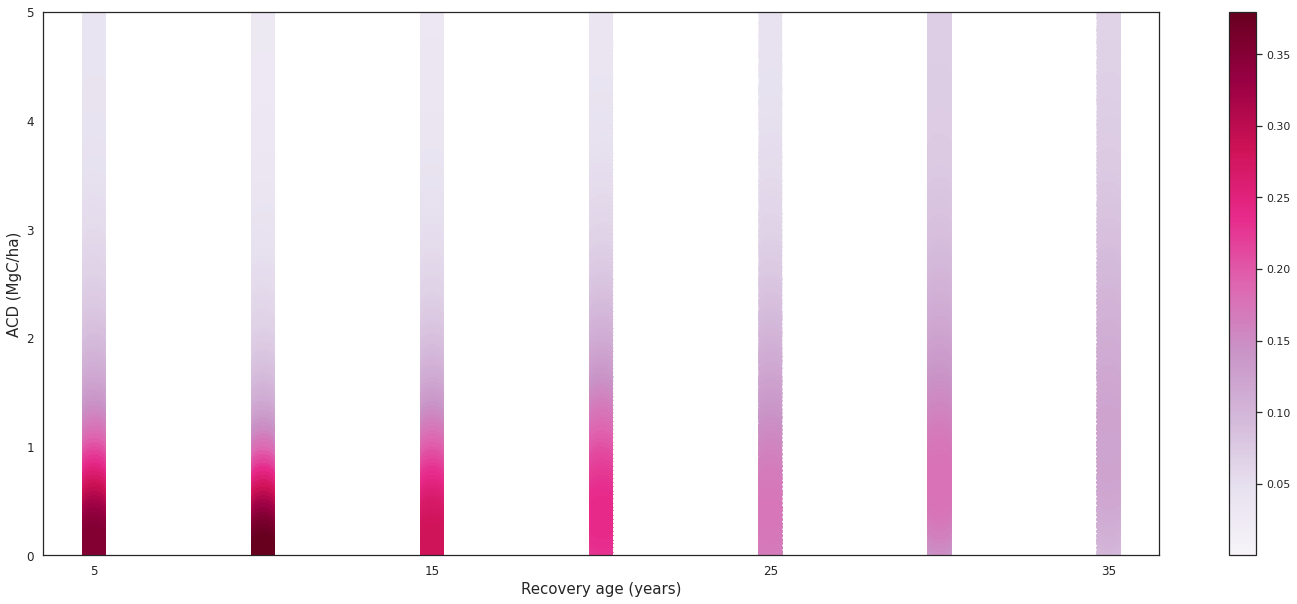

In [12]:
dft = closed(burned)
plot_pdf(dft[dft.severity == 2],
         'YSF_cat_5',
         'rh_50',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 5))

## Density Plots

In [41]:
low_c = sns.color_palette("rocket")[5]
mod_c = sns.color_palette("rocket")[3]
high_c = sns.color_palette("rocket")[0]

In [42]:
def kde_severity(data_frame, metric, severity, ax):
    dft = data_frame[data_frame.severity == severity]
    if severity == 0:
        color = low_c
    elif severity == 1:
        color = mod_c
    else:
        color = high_c
    sns.kdeplot(dft, x=metric, ax=ax, color=color)


In [43]:
def kde_before_after(df_b, df_u, metric, before, after):
    fig, ax = plt.subplots(1, 2, figsize=(25, 7))
    sns.kdeplot(df_u, x=metric, ax=ax[0], color="gray", linestyle="--")
    sns.kdeplot(df_u, x=metric, ax=ax[1], color="gray", linestyle="--")

    dft = df_b[df_b.YSF_cat_5 == before]
    for severity in [0, 1, 2]:
        kde_severity(dft, metric, severity, ax[0])


    dft = df_b[df_b.YSF_cat_5 == after]
    for severity in [0, 1, 2]:
        kde_severity(dft, metric, severity, ax[1])


In [44]:
def kde_open_closed(metric):
    kde_before_after (open(burned), open(unburned), metric, 5, 35)
    kde_before_after (closed(burned), closed(unburned), metric, 5, 35)

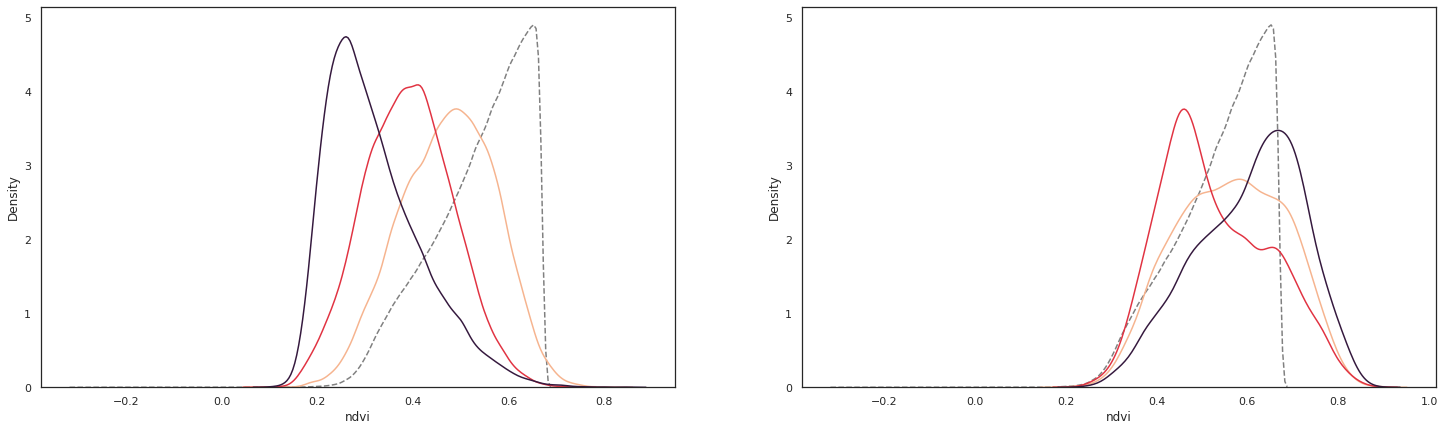

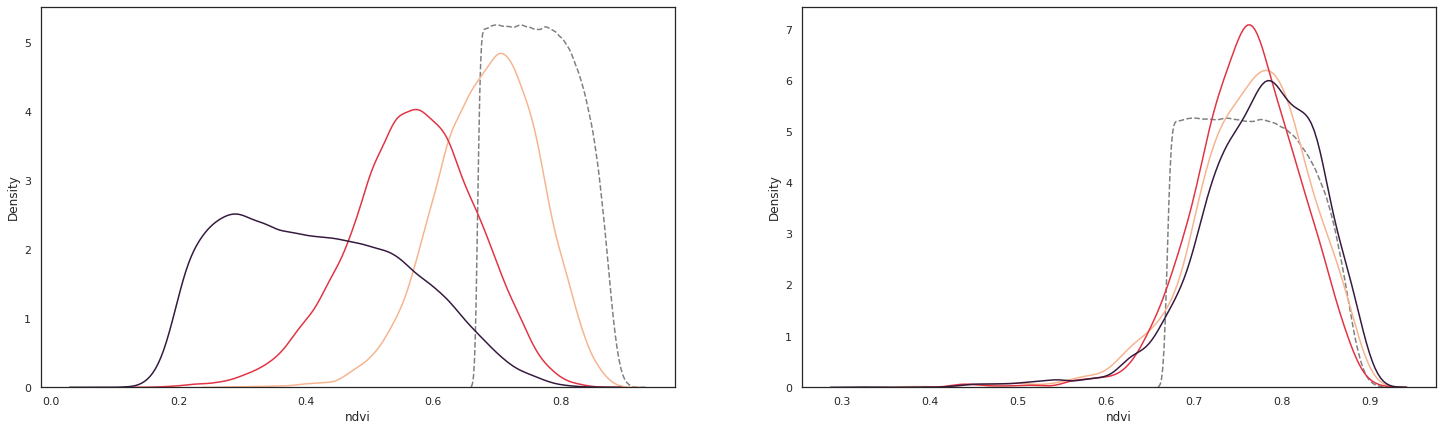

In [45]:
kde_open_closed("ndvi")

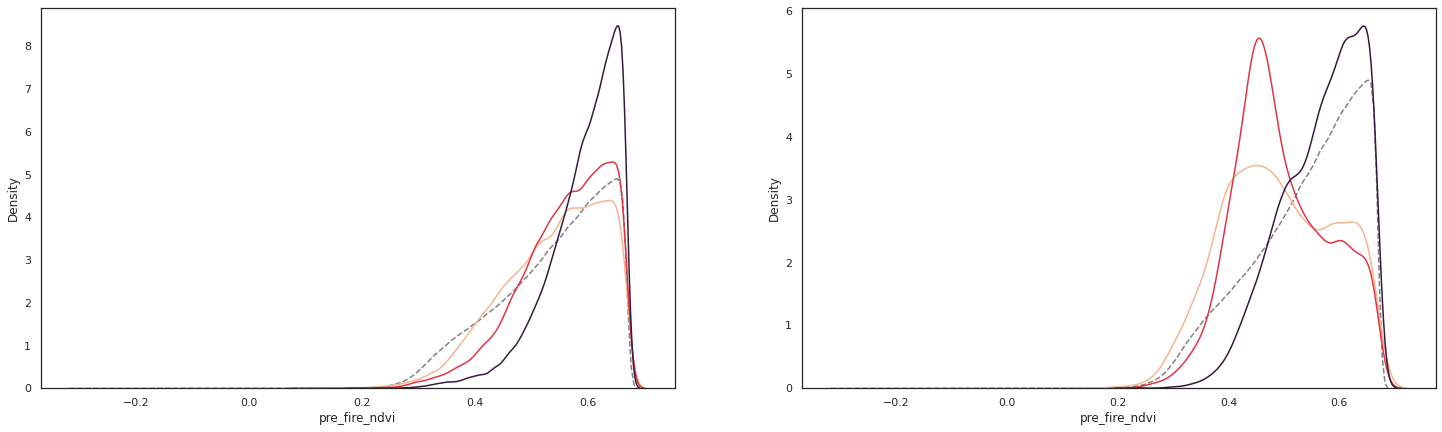

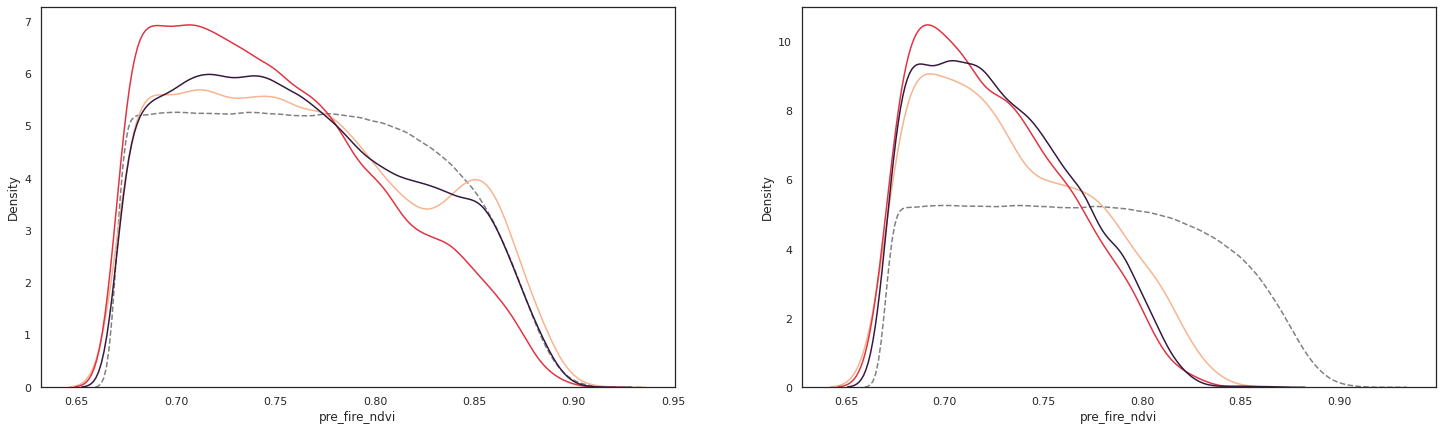

In [46]:
kde_open_closed("pre_fire_ndvi")

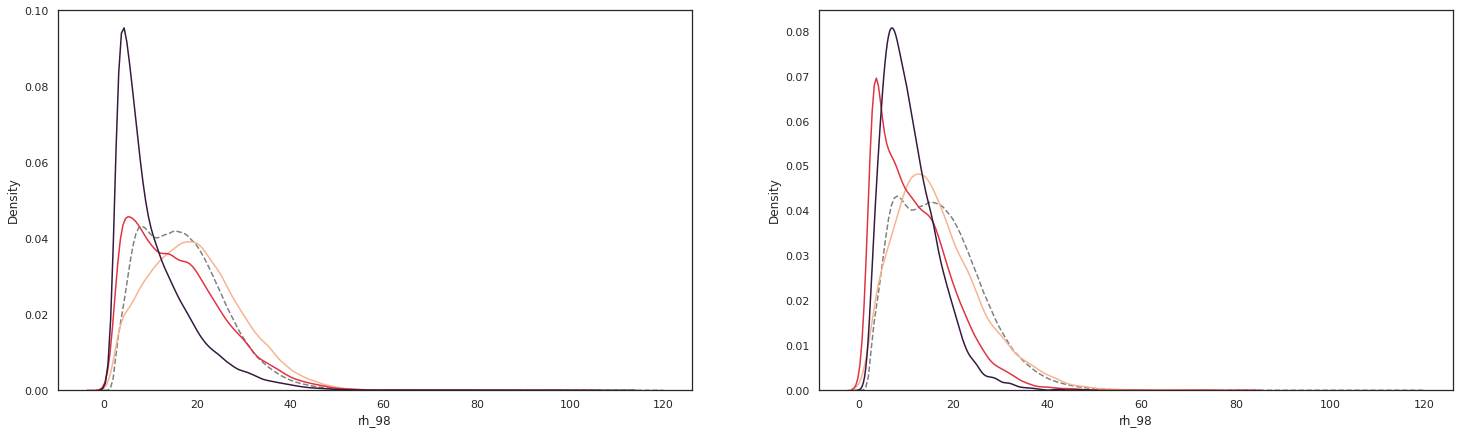

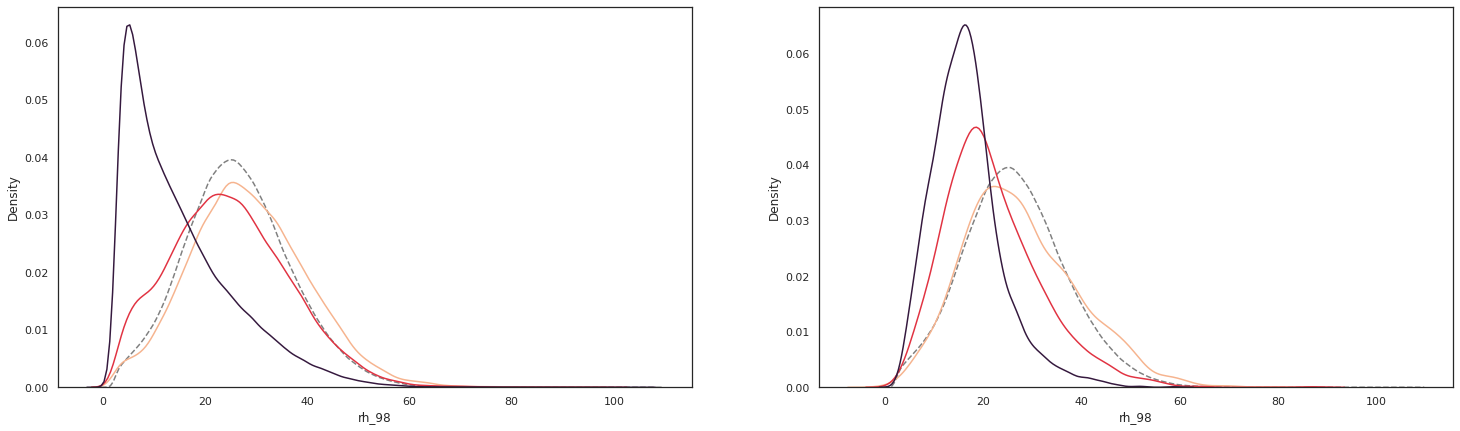

In [48]:
kde_open_closed("rh_98")

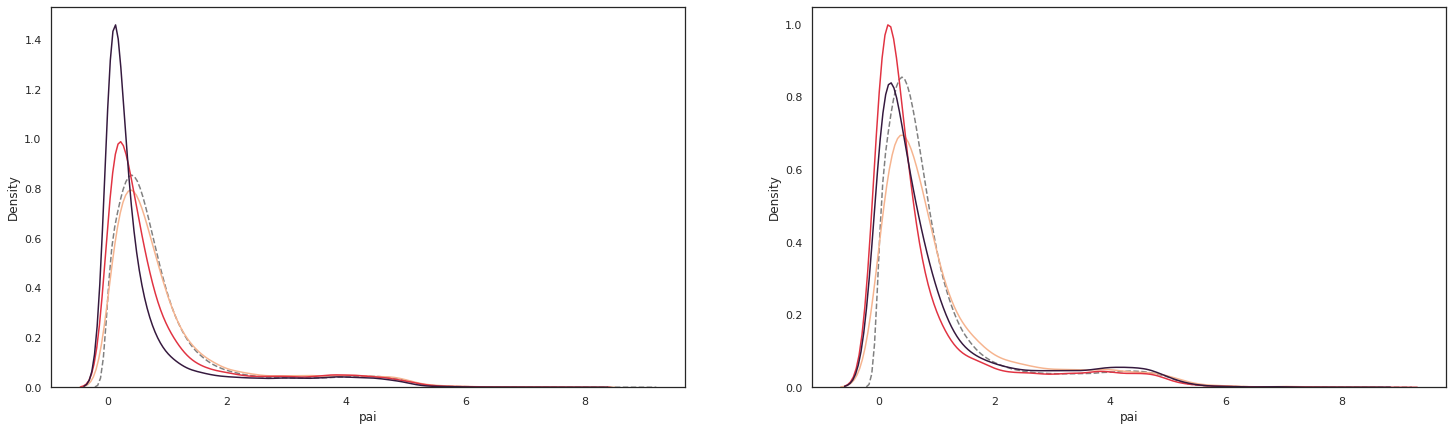

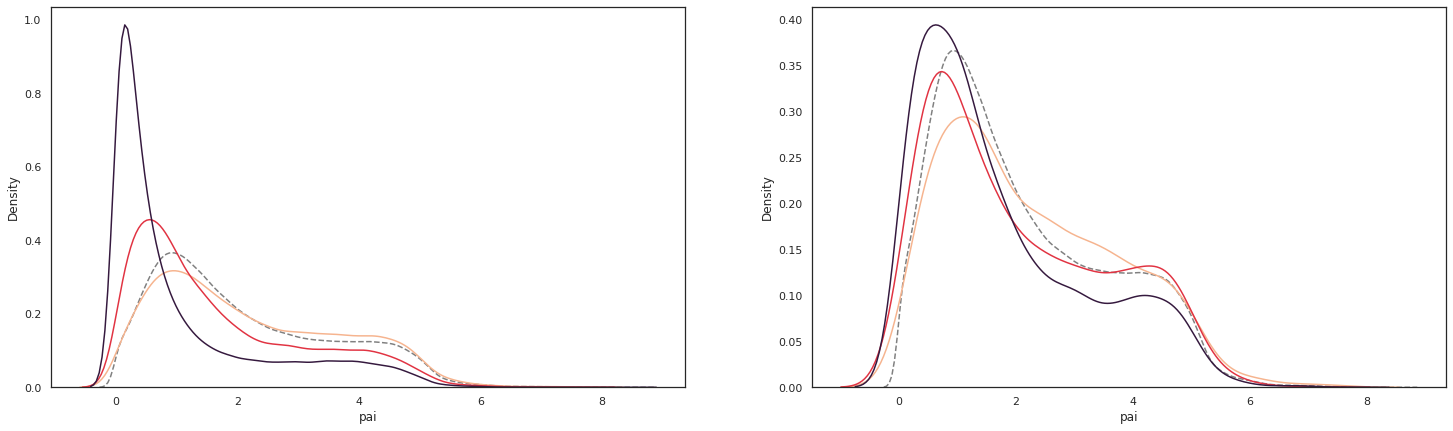

In [49]:
kde_open_closed("pai")

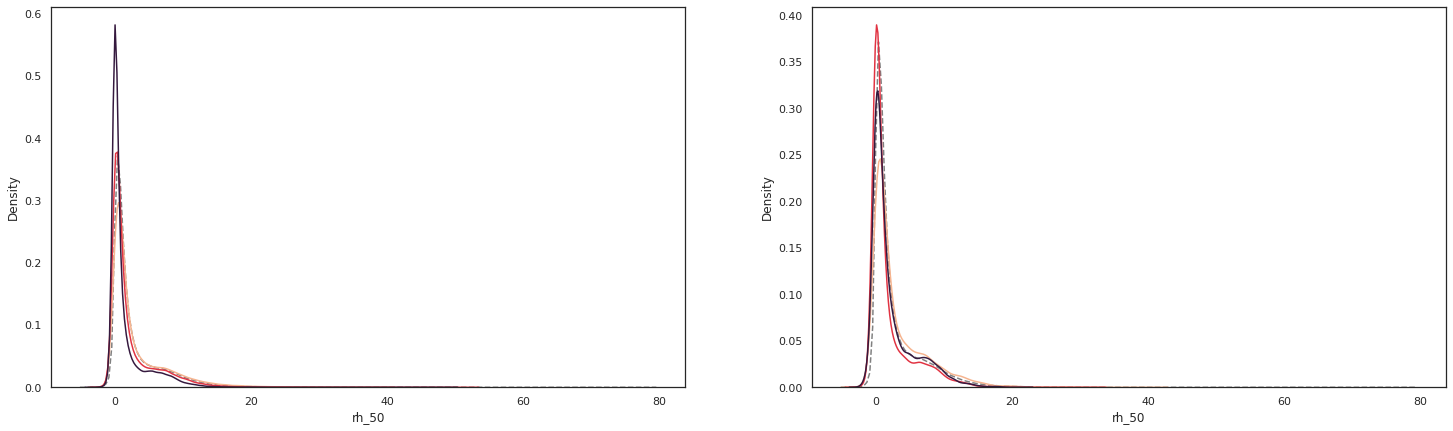

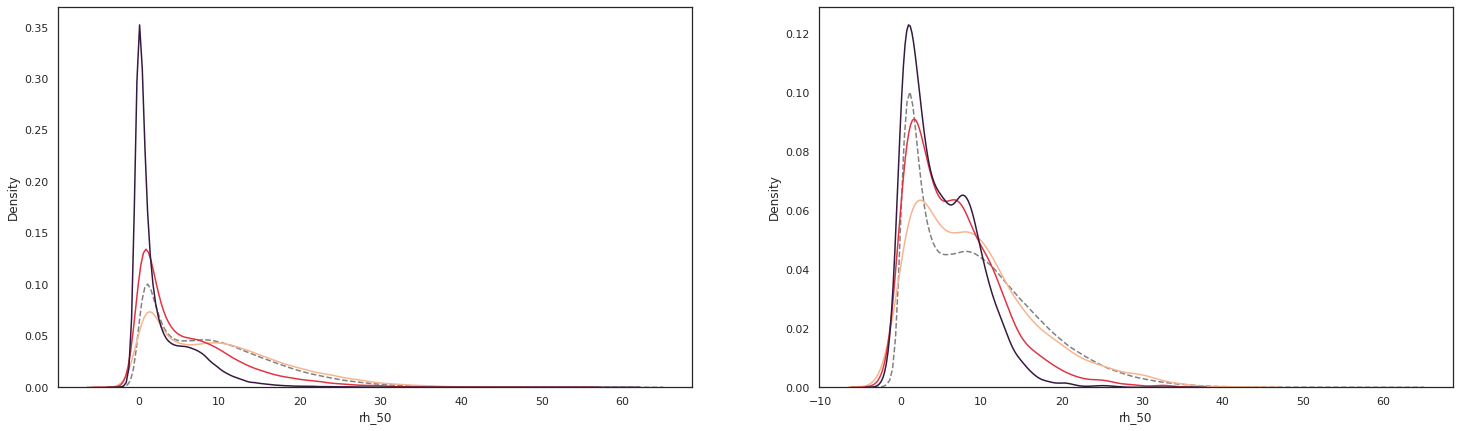

In [50]:
kde_open_closed("rh_50")

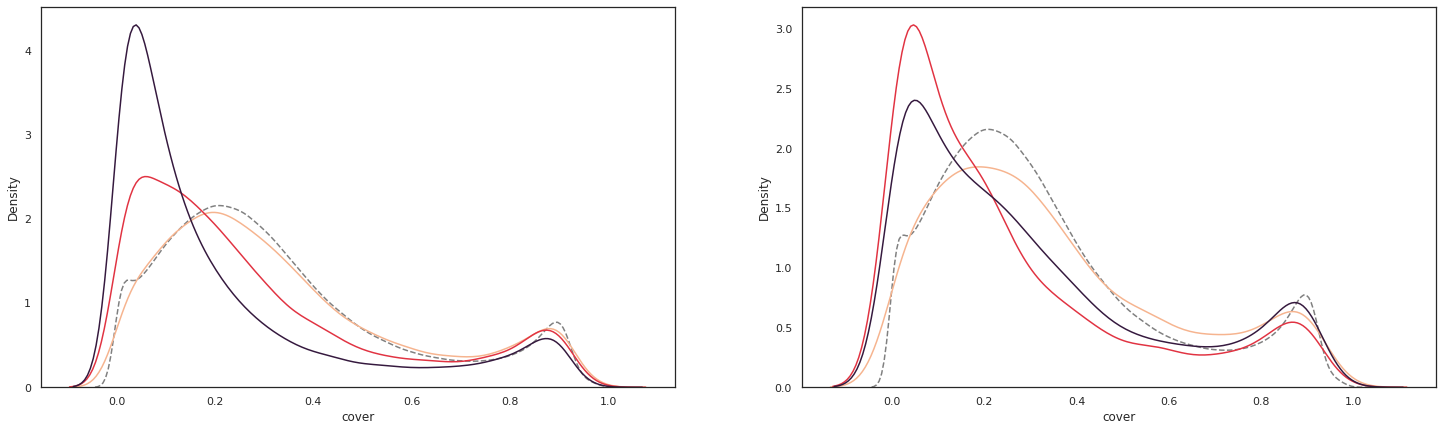

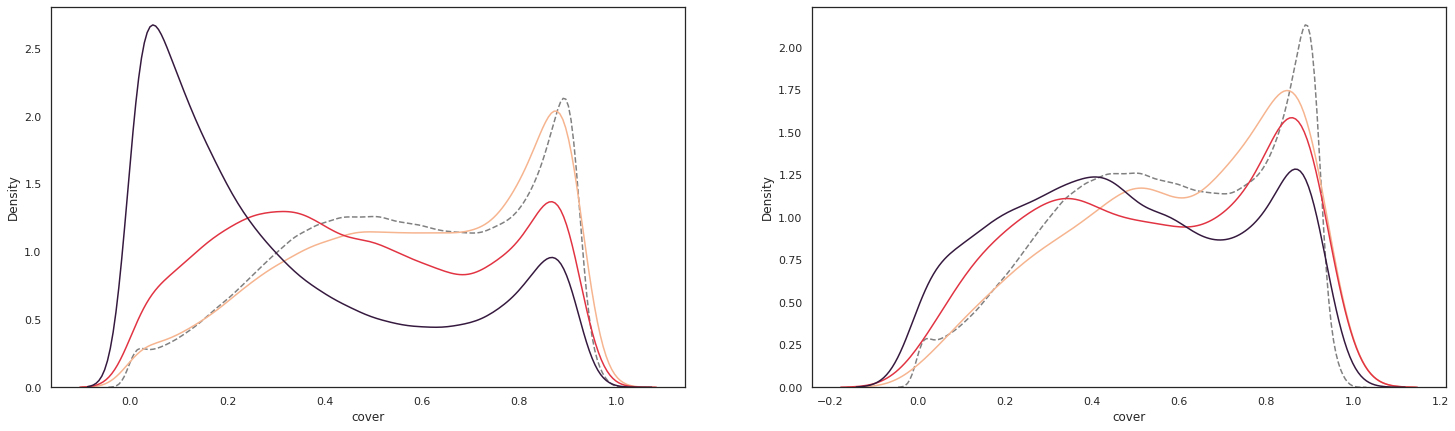

In [51]:
kde_open_closed("cover")

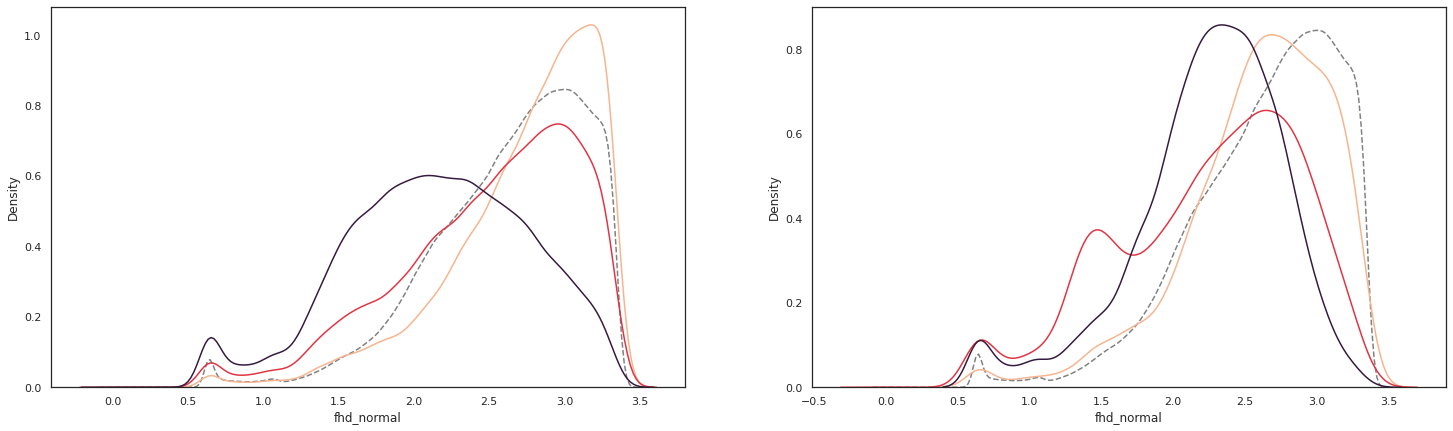

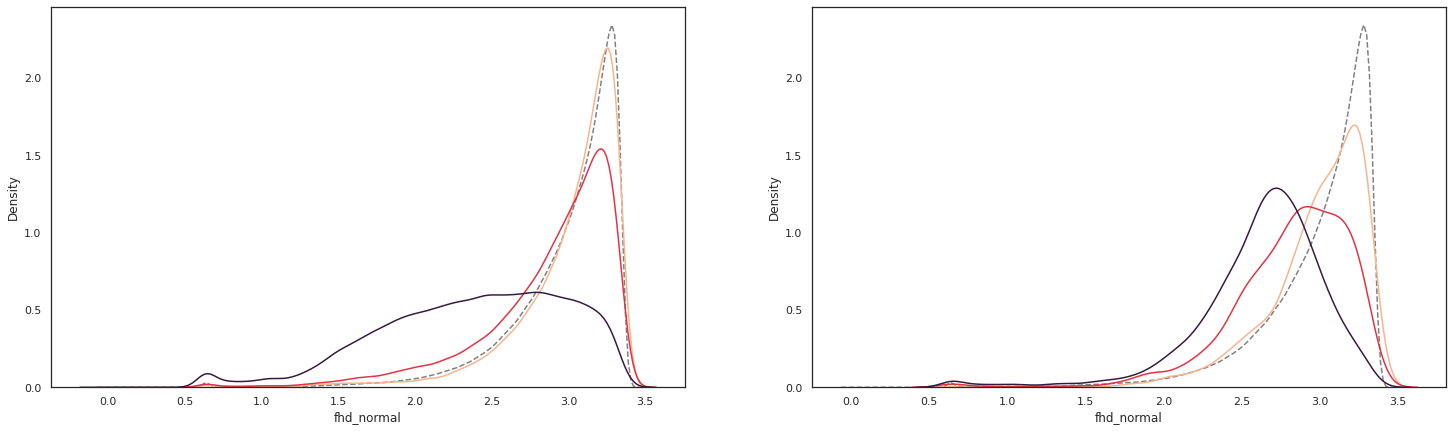

In [53]:
kde_open_closed("fhd_normal")

### Correlations

In [54]:
columns = [
 'fire_size_acres',
 'pre_fire_ndvi',
 'YSF',
 'YSF_cat_5',
 'agbd',
 'cover',
 'fhd_normal',
 'latitude',
 'longitude',
 'pai',
 'rh_25',
 'rh_50',
 'rh_70',
 'rh_98',
 'aspect',
 'elevation',
 'slope',
 'soil',
 'ndvi',
 'cover']

### Low Severity, Closed Canopy

In [56]:
# look at high-severity only
correlations_burned = closed(burned[burned.severity ==0])[columns + ["ndvi_ratio"]].corr()
correlations_unburned = closed(unburned)[columns].corr()
correlations_burned.pre_fire_ndvi

fire_size_acres   -0.104434
pre_fire_ndvi      1.000000
YSF               -0.084837
YSF_cat_5         -0.087644
agbd               0.373661
cover              0.336648
fhd_normal         0.238868
latitude           0.398086
longitude         -0.433419
pai                0.307332
rh_25              0.372390
rh_50              0.436107
rh_70              0.411661
rh_98              0.332274
aspect            -0.008386
elevation         -0.409551
slope              0.145668
soil              -0.083472
ndvi               0.584073
cover              0.336648
ndvi_ratio        -0.041199
Name: pre_fire_ndvi, dtype: float64

### High Severity

In [57]:
# look at high-severity only
correlations_burned = closed(burned[burned.severity == 2])[columns + ["ndvi_ratio"]].corr()
correlations_unburned = closed(unburned)[columns].corr()

In [58]:
correlations_burned.pre_fire_ndvi, correlations_unburned.pre_fire_ndvi

(fire_size_acres    0.014033
 pre_fire_ndvi      1.000000
 YSF               -0.163839
 YSF_cat_5         -0.162164
 agbd               0.163411
 cover              0.102986
 fhd_normal         0.112974
 latitude           0.169295
 longitude         -0.231466
 pai                0.092489
 rh_25              0.096602
 rh_50              0.132750
 rh_70              0.154583
 rh_98              0.172417
 aspect             0.023634
 elevation         -0.203074
 slope              0.098846
 soil              -0.073260
 ndvi               0.106110
 cover              0.102986
 ndvi_ratio        -0.093579
 Name: pre_fire_ndvi, dtype: float64,
 fire_size_acres         NaN
 pre_fire_ndvi      1.000000
 YSF                     NaN
 YSF_cat_5               NaN
 agbd               0.394763
 cover              0.391345
 fhd_normal         0.270865
 latitude           0.187759
 longitude         -0.320124
 pai                0.371614
 rh_25              0.433725
 rh_50              0.466386
 rh_7

In [59]:
correlations_burned.ndvi_ratio

fire_size_acres   -0.529762
pre_fire_ndvi     -0.093579
YSF                0.767993
YSF_cat_5          0.741827
agbd               0.078403
cover              0.156537
fhd_normal         0.146201
latitude           0.115375
longitude         -0.195390
pai                0.127856
rh_25              0.111603
rh_50              0.156437
rh_70              0.143107
rh_98              0.071318
aspect             0.047550
elevation         -0.247348
slope             -0.014080
soil               0.093694
ndvi               0.977684
cover              0.156537
ndvi_ratio         1.000000
Name: ndvi_ratio, dtype: float64

In [60]:
correlations_burned.rh_70, correlations_unburned.rh_70

(fire_size_acres   -0.039229
 pre_fire_ndvi      0.154583
 YSF                0.098511
 YSF_cat_5          0.105425
 agbd               0.926658
 cover              0.784722
 fhd_normal         0.624551
 latitude          -0.017589
 longitude         -0.009175
 pai                0.743268
 rh_25              0.770067
 rh_50              0.907392
 rh_70              1.000000
 rh_98              0.775405
 aspect            -0.000884
 elevation         -0.078252
 slope              0.255378
 soil               0.029086
 ndvi               0.174929
 cover              0.784722
 ndvi_ratio         0.143107
 Name: rh_70, dtype: float64,
 fire_size_acres         NaN
 pre_fire_ndvi      0.427140
 YSF                     NaN
 YSF_cat_5               NaN
 agbd               0.966349
 cover              0.726053
 fhd_normal         0.602726
 latitude           0.048139
 longitude         -0.103708
 pai                0.663254
 rh_25              0.719785
 rh_50              0.913595
 rh_70       

In [61]:
correlations_burned.pai, correlations_unburned.pai

(fire_size_acres   -0.052989
 pre_fire_ndvi      0.092489
 YSF                0.112186
 YSF_cat_5          0.115943
 agbd               0.575756
 cover              0.958582
 fhd_normal         0.479855
 latitude          -0.020227
 longitude         -0.010435
 pai                1.000000
 rh_25              0.956570
 rh_50              0.867205
 rh_70              0.743268
 rh_98              0.517004
 aspect             0.006532
 elevation         -0.107658
 slope              0.275644
 soil               0.012506
 ndvi               0.146475
 cover              0.958582
 ndvi_ratio         0.127856
 Name: pai, dtype: float64,
 fire_size_acres         NaN
 pre_fire_ndvi      0.371614
 YSF                     NaN
 YSF_cat_5               NaN
 agbd               0.581477
 cover              0.947121
 fhd_normal         0.323949
 latitude           0.003385
 longitude         -0.091083
 pai                1.000000
 rh_25              0.866951
 rh_50              0.760090
 rh_70         

In [62]:
correlations_burned.YSF, correlations_burned.YSF_cat_5

(fire_size_acres   -0.421966
 pre_fire_ndvi     -0.163839
 YSF                1.000000
 YSF_cat_5          0.991280
 agbd               0.011692
 cover              0.144988
 fhd_normal         0.085126
 latitude           0.295534
 longitude         -0.347792
 pai                0.112186
 rh_25              0.100329
 rh_50              0.126288
 rh_70              0.098511
 rh_98             -0.011552
 aspect             0.044414
 elevation         -0.225887
 slope             -0.121255
 soil               0.134154
 ndvi               0.723589
 cover              0.144988
 ndvi_ratio         0.767993
 Name: YSF, dtype: float64,
 fire_size_acres   -0.387178
 pre_fire_ndvi     -0.162164
 YSF                0.991280
 YSF_cat_5          1.000000
 agbd               0.017913
 cover              0.150527
 fhd_normal         0.091786
 latitude           0.296087
 longitude         -0.342819
 pai                0.115943
 rh_25              0.104535
 rh_50              0.130836
 rh_70         

## Plot Correlations

In [63]:
dfp = closed(burned[burned.severity == 2])

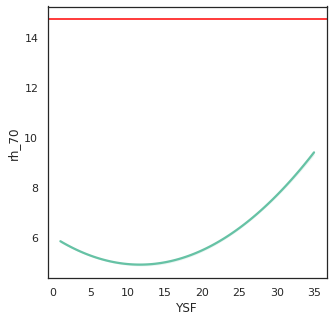

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="rh_70", scatter=False, order=2)
ax.axhline(closed(unburned).rh_70.mean(), color="red")

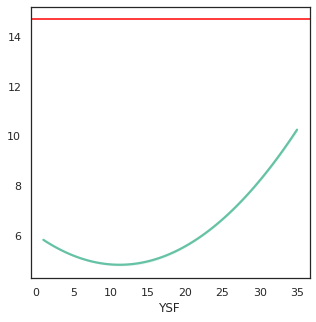

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="rh_70",  y_partial="slope", scatter=False, order=2)
ax.axhline(closed(unburned).rh_70.mean(), color="red")

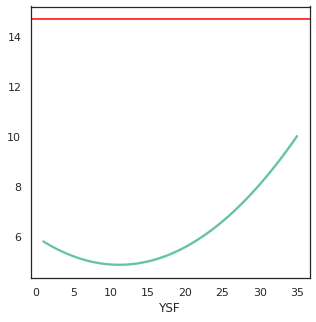

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="rh_70", scatter=False, y_partial="pre_fire_ndvi", order=2)
ax.axhline(closed(unburned).rh_70.mean(), color="red")

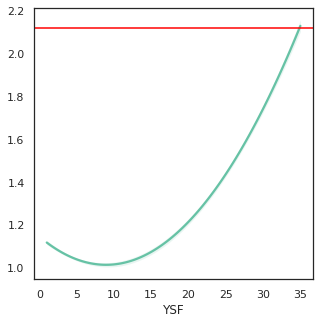

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.regplot(dfp, x="YSF", y="pai", scatter=False, y_partial="slope", order=2)
ax.axhline(closed(unburned).pai.mean(), color="red")